<div class="alert alert-block alert-success">
<b>Imported libraries</b>
</div>

In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import timedelta
from pandas_datareader import data
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_style('white')

C:\Users\Sif\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


<div class="alert alert-block alert-info">
<b>Building date range</b>
</div>

In [2]:
end = dt.datetime.now()
start = end - timedelta(days = 180)
asset = 'BABA'

<div class="alert alert-block alert-info">
<b>Loading the asset data</b>
</div>

In [3]:
# For a brazilian stock as FLRY3 you have to put a .SA so it will be FLRY3.SA
df = data.DataReader(asset, 'yahoo', start, end)
# Drop first month if wanted
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-05-10,222.869995,218.559998,222.869995,219.529999,17266700,219.529999
2021-05-11,221.389999,213.000000,213.710007,221.380005,13887700,221.380005
2021-05-12,225.289993,219.000000,224.740005,219.899994,20366900,219.899994
2021-05-13,215.500000,204.389999,213.149994,206.080002,51693900,206.080002
2021-05-14,210.940002,206.020004,209.923996,209.509995,31600800,209.509995


<div class="alert alert-block alert-info">
<b>Getting the moving average</b>
</div>

In [4]:
asset = pd.DataFrame()
asset['adj close'] = df['Adj Close']
asset['MM3'] = asset['adj close'].rolling(3).mean()
asset['MM6'] = asset['adj close'].rolling(5).mean()
asset['MM9'] = asset['adj close'].rolling(7).mean()
asset = asset.stack().reset_index().rename(columns = {'Date': 'date', 
                                                    'level_1': 'variable', 0: 'value' })
asset.set_index('date', inplace = True)
asset.tail()

,variable,value
date,,
2021-05-13,MM9,220.771428
2021-05-14,adj close,209.509995
2021-05-14,MM3,211.829997
2021-05-14,MM6,215.279999
2021-05-14,MM9,218.304284


<div class="alert alert-block alert-info">
<b>Getting the last 4 days price movement</b>
</div>

In [5]:
# You can use: baba_day = df[['Adj Close']].copy() or:
# baba_day = pd.DataFrame(df['Adj Close'].copy())
asset_day = pd.DataFrame(df['Adj Close'].copy())
asset_day.rename(columns = {'Adj Close': 'adj close'}, inplace = True)
asset_day['d1'] = asset_day['adj close'].shift(1)
asset_day['d2'] = asset_day['adj close'].shift(2)
asset_day['d3'] = asset_day['adj close'].shift(3)
asset_day['d4'] = asset_day['adj close'].shift(4)
asset_day = asset_day.dropna()
asset_day.tail()

,adj close,d1,d2,d3,d4
Date,,,,,
2021-05-10,219.529999,225.309998,226.419998,226.779999,227.899994
2021-05-11,221.380005,219.529999,225.309998,226.419998,226.779999
2021-05-12,219.899994,221.380005,219.529999,225.309998,226.419998
2021-05-13,206.080002,219.899994,221.380005,219.529999,225.309998
2021-05-14,209.509995,206.080002,219.899994,221.380005,219.529999


<div class="alert alert-block alert-info">
<b>Multiple linear regression</b>
</div>

In [6]:
X1 = sm.add_constant(asset_day.drop('adj close', axis = 1))
# Same thing as X1 = sm.add_constant(asset_day[['d1', 'd2', 'd3', 'd4']])
model = sm.OLS(endog = asset_day['adj close'], exog = X1, missing = 'drop')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              adj close   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     176.6
Date:                Sat, 15 May 2021   Prob (F-statistic):           4.08e-48
Time:                        04:10:23   Log-Likelihood:                -393.95
No. Observations:                 120   AIC:                             797.9
Df Residuals:                     115   BIC:                             811.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9762      9.322      1.070      0.287      -8.490      28.442
d1             0.8192      0.093      8.814      0.000       0.635       1.003
d2             0.0940      0.122      0.771      0.442      -0.147       0.335
d3            -0.0009      0.123     -0.008      0.994      -0.244       0.242
d4             0.0450      0.096      0.470      0.640      -0.145       0.235
==============================================================================
Omnibus:                       31.793   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.869
Skew:                          -0.726   Prob(JB):                     1.05e-33
Kurtosis:                       8.316   Cond. No.                     7.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<div class="alert alert-block alert-info">
<b>Variance inflation factor</b>
</div>

In [7]:
vif = pd.DataFrame()
asset_day = add_constant(asset_day) # to add 1 as constant inside the dataframe
# df = df.assign(const = 1) to put const in the end
X = asset_day.drop(['adj close'], axis = 1) # drop the endog variable and get all other variables
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variables,VIF
0,const,240.293050
1,d1,6.896219
2,d2,11.381183
3,d3,11.324374
4,d4,6.829239


<div class="alert alert-block alert-info">
<b>Residual's Probability Density Function</b>
</div>

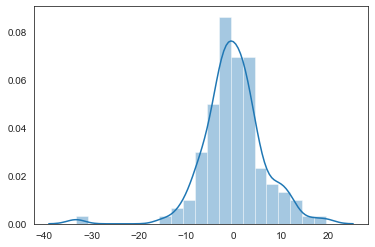

In [8]:
sns.distplot(results.resid)
plt.show()

<div class="alert alert-block alert-info">
<b>Getting the model's score</b>
</div>

In [9]:
X2 = asset_day.drop(['adj close', 'const'], axis = 1)
y = asset_day['adj close']

model_sk = LinearRegression()
fit = model_sk.fit(X2, y)
score = model_sk.score(X2, y)
score

0.8599696612987996

<div class="alert alert-block alert-info">
<b>Predict the asset's next day adj close price</b>
</div>

In [10]:
X_test = asset_day['adj close'].tail(4).sort_values(ascending = False).values.reshape(1, 4)
model_sk.predict(X_test)

array([221.06175036])